In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
housing_data = pd.read_csv('./housing.csv')
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

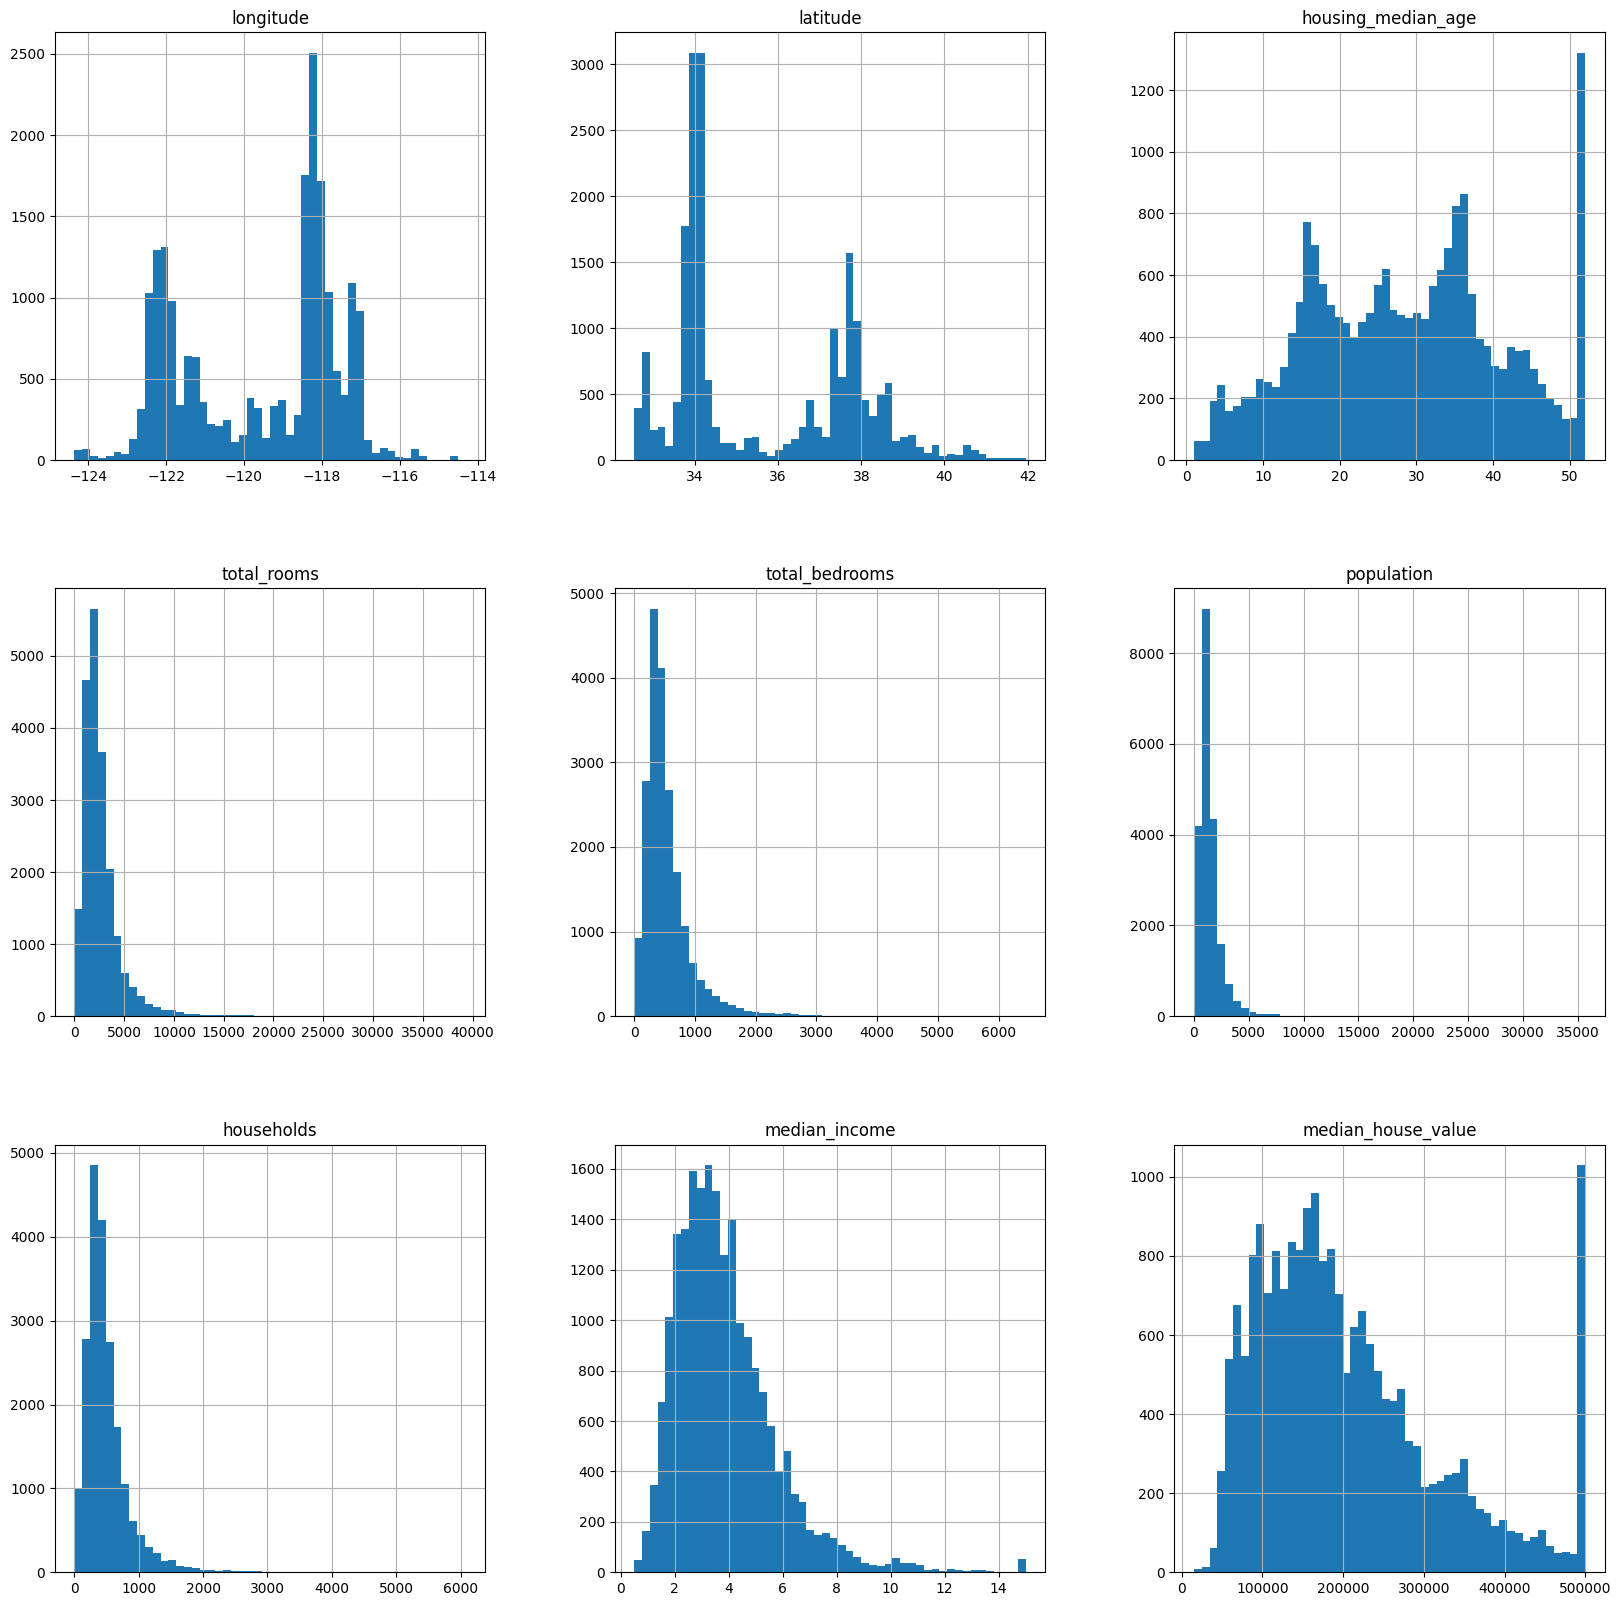

In [8]:
housing_data.hist(figsize=(20,20), bins=50)

<Axes: xlabel='longitude', ylabel='latitude'>

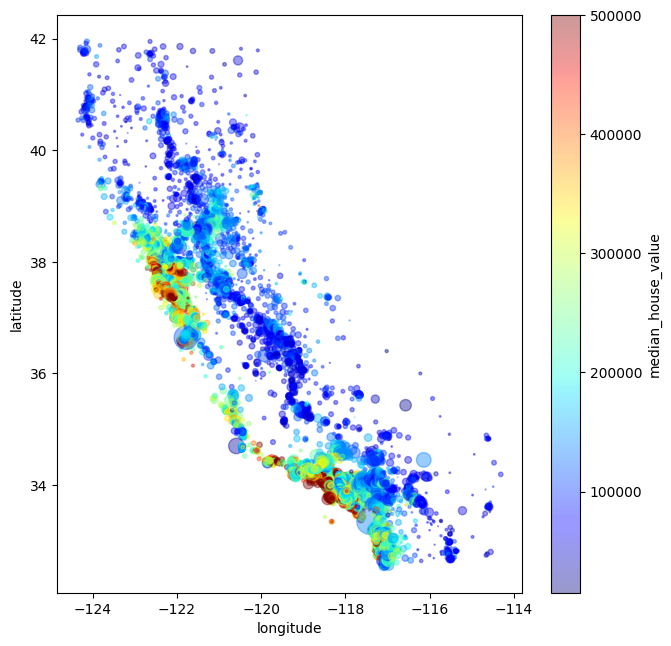

In [9]:
housing_data.plot(kind='scatter', x='longitude', y='latitude', c='median_house_value', s=housing_data['population']/100, alpha=0.4, figsize=(7.5, 7.5), cmap=plt.get_cmap("jet"), colorbar=True)

In [10]:
import numpy as np

# def split_train_test(data, test_ratio):
#     from sklearn.model_selection import StratifiedShuffleSplit

#     shuffled_indices = np.random.permutation(len(data))
#     # returns array with ints upto len randomly shuffled
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size:]

#     split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#     for train_index, test_index in split.split(housing_data, housing_data['income_cat']):

#     return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
housing_data['income_cat'] = pd.cut(housing_data['median_income'], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

<Axes: >

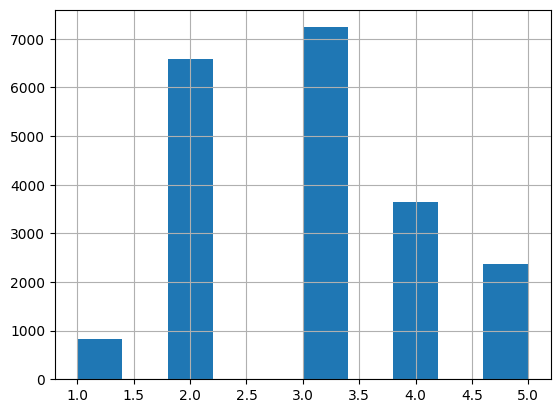

In [12]:
housing_data['income_cat'].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [14]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [15]:
housing_data = strat_train_set.copy()

In [16]:
corr_mat = housing_data.drop('ocean_proximity', axis=1).corr()

In [17]:
corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

when close to one, means directly proportional, -1 inversely, 0 means no linear relation

In [18]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')
#filling na values

In [19]:
housing_num = housing_data.drop('ocean_proximity', axis=1)

imp.fit(housing_num)

SimpleImputer(strategy='median')

In [20]:
imp.statistics_

array([-1.18510e+02,  3.42600e+01,  2.90000e+01,  2.11900e+03,
        4.33000e+02,  1.16400e+03,  4.08000e+02,  3.54155e+00,
        1.79500e+05])

In [21]:
housing_tr = pd.DataFrame(imp.transform(housing_num), columns=housing_num.columns)

In [22]:
from sklearn.preprocessing import OrdinalEncoder
#encode string feature classes into integer classes
#however can cause issues as some models may consider closer numerical values
#to be closer, which might not be the case for our classes
ord = OrdinalEncoder()

In [23]:
#use one hot encoding instead
from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder()

In [24]:
ocean_distance = ohenc.fit_transform(housing_data[['ocean_proximity']])
print(ocean_distance.max())

1.0


In [25]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombineAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rph = X[:, 3] / X[:, 6]
        pph = X[:, 6] / X[:, 5]

        if self.add_bedrooms_per_room:
            bpr = X[:, 3] / X[:, 4]
            return np.c_[X, rph, pph, bpr]
        else:
            return np.c_[X, rph, pph]

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('combiner', CombineAttributeAdder()),
    ('scaler', StandardScaler())
])

In [49]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, housing_data.drop(['ocean_proximity', 'median_house_value'], axis=1).columns),
    ('cat', OneHotEncoder(), ['ocean_proximity'])
])

In [58]:
housing_data = strat_train_set.copy().drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_prep = full_pipeline.fit_transform(housing_data)

In [59]:
housing_df = pd.DataFrame(housing_prep)

In [60]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       16512 non-null  float64
 1   1       16512 non-null  float64
 2   2       16512 non-null  float64
 3   3       16512 non-null  float64
 4   4       16512 non-null  float64
 5   5       16512 non-null  float64
 6   6       16512 non-null  float64
 7   7       16512 non-null  float64
 8   8       16512 non-null  float64
 9   9       16512 non-null  float64
 10  10      16512 non-null  float64
 11  11      16512 non-null  float64
 12  12      16512 non-null  float64
 13  13      16512 non-null  float64
 14  14      16512 non-null  float64
 15  15      16512 non-null  float64
dtypes: float64(16)
memory usage: 2.0 MB


In [61]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prep, housing_labels)

LinearRegression()

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(housing_prep, housing_labels)

DecisionTreeRegressor()

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree, housing_prep, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [66]:
print(tree_rmse_scores.std())

2805.1626669707202
